# Julia Adaptive Mesh PDE Solver

In [162]:
using RegionTrees
import RegionTrees: AbstractRefinery, needs_refinement, refine_data
using StaticArrays: SVector
using SparseArrays
using Plots
using DataStructures
using Base.Threads

## Quad Tree Functions

In [2]:
function plot_qtree(root)
    plt = plot(xlim=(0, 1), ylim=(0,1), legend=nothing)
    for leaf in allleaves(root)
        v = hcat(collect(vertices(leaf.boundary))...)
        plot!(plt, v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
    end
    plt
end

plot_qtree (generic function with 1 method)

In [3]:
# A circle in the middle at some val 1
function initial_state(x,y)
    if (x-0.5)^2 + (y-0.5)^2 < 0.2^2
        return 1
    else
        return 0
    end
end

initial_state (generic function with 1 method)

In [4]:
struct MyRefinery <: AbstractRefinery
    maxderiv
    minwidth
end

In [5]:
function needs_refinement(mr::MyRefinery, cell::Cell{Float64, 2, Float64, 4})
    # Don't refine if at the finest resolution
    if cell.boundary.widths[1] <= mr.minwidth
        return false
    end

    # Loop through the vertices, check derive compared to neighbor
    verts = vertices(cell)
    for i in 1:4
        x1,y1 = verts[i]
        x2,y2 = verts[(i%4)+1]
        deriv = abs(initial_state(x1,y1) - initial_state(x2,y2))/cell.boundary.widths[1]
        if deriv > mr.maxderiv
            return true
        end
    end
    false
end

needs_refinement (generic function with 2 methods)

In [6]:
function refine_data(::MyRefinery, ::Cell, indices)
    0.0
end

refine_data (generic function with 2 methods)

In [7]:
function find_position_idx(node)
    # Find which direction this child is
    # 1 -> SW -> 1,1
    # 2 -> SE -> 2,1
    # 3 -> NW -> 1,2
    # 4 -> NE -> 2,2
    idx = 0
    for i in 1:2, j in 1:2
        idx = j +(i-1)*2
        if node == parent(node).children[i,j]
            return idx
        end
    end
    0
end

find_position_idx (generic function with 1 method)

In [8]:
function north_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # If it's a south child, return the north child
    if idx == 1
        return parent(node).children[1,2]
    end
    if idx == 2
        return parent(node).children[2,2]
    end
    # If its a north child, get the north neighbor of the parent
    v = north_nearest_neighbor(parent(node))
    # If the parent north neighbor doesn't have children, or doesn't exist, return it
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching south child of the parent north neighbor
        if idx == 3 # West
            return v.children[1,1]
        else        # East
            return v.children[2,1]
        end
    end
end

north_nearest_neighbor (generic function with 1 method)

In [9]:
function south_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # If its a north child, return the south child
    if idx == 3
        return parent(node).children[1,1]
    end
    if idx == 4
        return parent(node).children[2,1]
    end
    # If it's a south child, get the south neighbor of the parent
    v = south_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching north child of the parent south neigbor
        if idx == 1
            return v.children[1,2]
        else
            return v.children[2,2]
        end
    end
end

south_nearest_neighbor (generic function with 1 method)

In [10]:
function east_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # if its a west child, return the east child
    if idx == 1
        return parent(node).children[2,1]
    end
    if idx == 3
        return parent(node).children[2,2]
    end
    # If it's an east child, get the east neighbor of the parent
    v = east_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching west child of the parent east neighbor
        if idx == 2
            return v.children[1,1]
        else
            return v.children[1,2]
        end
    end
end

east_nearest_neighbor (generic function with 1 method)

In [11]:
function west_nearest_neighbor(node)
    # If it's the root, no neighbor
    if parent(node) == nothing
        return nothing
    end
    idx = find_position_idx(node)
    # if it's an east child, return the west child
    if idx == 2
        return parent(node).children[1,1]
    end
    if idx == 4
        return parent(node).children[1,2]
    end
    # If it's a west child, return the west neighbor of the parent
    v = west_nearest_neighbor(parent(node))
    if v == nothing || isleaf(v)
        return v
    else
        # Return the matching east child of the parent west neighbor
        if idx == 1
            return v.children[2,1]
        else
            return v.children[2,2]
        end
    end
end

west_nearest_neighbor (generic function with 1 method)

In [12]:
function balance_quad_tree(root)
    queue = collect(allleaves(root))
    println("queue starting with $(length(queue)) elements")
    while !isempty(queue)
        # Get the next cell to check
        node = pop!(queue)
        # Start checking if it needs to split, assume no at the start
        needs_to_split = false
        # Get the nearest neighbors and check them
        # if it has adjacent children that aren't leaves We have to split.
        # If we find we have to split, we can skip searching the other neighbors
        nn = north_nearest_neighbor(node)
        if nn != nothing && nn.children != nothing && (!isleaf(nn.children[1,1]) || !isleaf(nn.children[2,1]))
            needs_to_split = true
        end
        sn = south_nearest_neighbor(node)
        if !needs_to_split && sn != nothing && sn.children != nothing && (!isleaf(sn.children[1,2]) || !isleaf(sn.children[2,2]))
            needs_to_split = true
        end
        en = east_nearest_neighbor(node)
        if !needs_to_split && en != nothing && en.children != nothing && (!isleaf(en.children[1,1]) || !isleaf(en.children[1,2]))
            needs_to_split = true
        end
        wn = west_nearest_neighbor(node)
        if !needs_to_split && wn != nothing && wn.children != nothing && (!isleaf(wn.children[2,1]) || !isleaf(wn.children[2,2]))
            needs_to_split = true
        end

        if needs_to_split
            split!(node)
            # Add new leaves to the queue
            vcat(queue, reshape(collect(node.children), 4))
            # Check if neightbor now needs to split
            if nn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, nn)
            end
            if sn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, sn)
            end
            if en.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, en)
            end
            if wn.boundary.widths[1] > node.boundary.widths[1]
                append!(queue, wn)
            end
        end
    end
end

balance_quad_tree (generic function with 1 method)

In [13]:
function quadtree_to_sparse_array(root)
    # Secret tool that will help us later (it maps counting the four children to their proper corner index)
    idx_map = Dict(1=>2,2=>4,3=>1,4=>3)

    # Initialize the array
    # Get the smallest stride (finest resolution)
    stride = minimum([leaf.boundary.widths for leaf in allleaves(root)])[1]
    # number of squares per dimension of the matrix
    dim = Int(1/stride)
    # Create the array, 1+num squares for the points
    arr = spzeros(dim+1,dim+1)

    # Iterate over the quadtree and add nodes to the array
    for cell in allcells(root)
        if !isleaf(cell)
            # Add centerpoints
            x,y = (Int.(dim*RegionTrees.center(cell)) .+ 1)
            j = x
            i = (dim+2)-y
            arr[i,j] = 1
            # Add midpoints from child divisions
            for (idx,val) in enumerate(cell.children)
                x,y = (Int.(dim*vertices(val)[idx_map[idx]]).+1)
                j = x
                i = (dim+2)-y
                arr[i,j] = 1
                # arr[(Int.(dim*vertices(val)[idx_map[idx]]).+1)...] = 1
            end
        end
    end
    # Add the corners of the root node
    for (idx,val) in enumerate(vertices(root))
        x,y = (Int.(dim*val).+1) 
        j = x
        i = (dim+2)-y
        arr[i,j] = 1
        # arr[(Int.(dim*val).+1)...] = 1
    end
    arr
end


quadtree_to_sparse_array (generic function with 1 method)

## Testing

### Create the adapted quadtree

In [14]:
# Generate the base quadtree
# The input domain will always be 0-1
root = Cell(SVector(0., 0), SVector(1.,1),0.0)
# Split out to the default resolution (1/16, 1/2^3)
f(a,b) = 0.0
split!(root)                # 1/2
for leaf in allleaves(root) # 1/4
    split!(leaf,f)
end
for leaf in allleaves(root) # 1/8
    split!(leaf,f)
end
for leaf in allleaves(root) # 1/16
    split!(leaf,f)
end

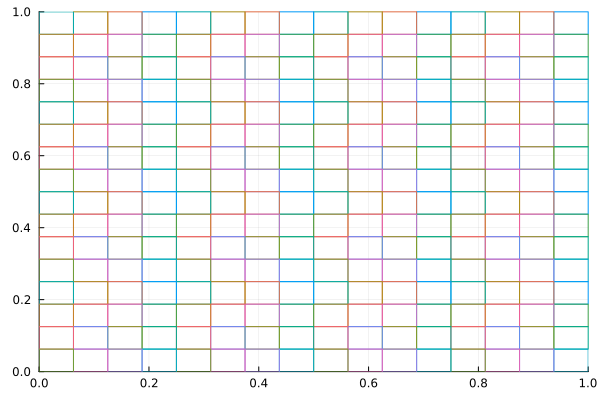

In [15]:
plot_qtree(root)

In [16]:
boundary = RegionTrees.HyperRectangle(SVector(0., 0), SVector(1., 1))
refinery = MyRefinery(0.3,1/(2^6))
# root = RegionTrees.Cell(boundary, 0.0)

refinery = MyRefinery(0.3,1/(2^6))
for leaf in allleaves(root)
    adaptivesampling!(leaf, refinery)
end

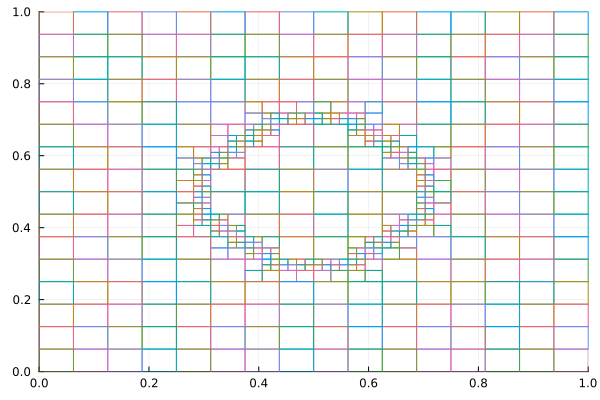

In [17]:
plot_qtree(root)

In [18]:
balance_quad_tree(root)

queue starting with 496 elements

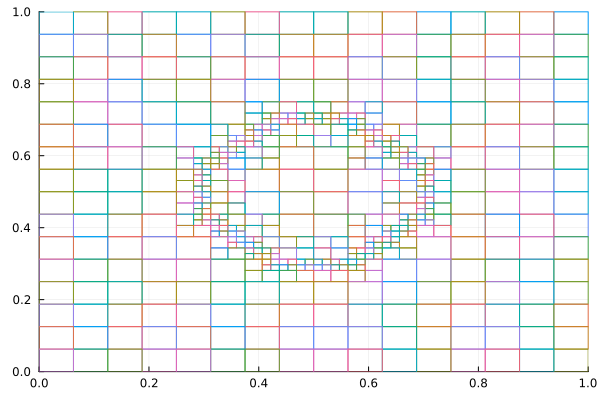

In [19]:
plot_qtree(root)

### Convert to sparse array and partition

In [139]:
function init_arr(arr, func)
    Δh = 1/(arr.m-1)
    x,y, = findnz(arr)
    for (x,y,v) in zip(findnz(arr)...)
        if func(x*Δh,y*Δh) == 1
            arr[x,y] = 100
        end
    end
end

init_arr (generic function with 1 method)

In [59]:
# Get Start and stop column indices
# arr = Sparse array to partition
# n = number of partitions to make
# Returns:
# partitions -> list of 2 element tuples specifiying start and end indices of the column partitions
# part_counts -> list of the number of elements in each partition, should be relatively similar
function get_partitions(arr, n)
    nele = nnz(arr) # number of used elements in sparse array
    nsplit = nele÷n # target number of elements in each split
    ele_tol = 0.1*nsplit    # tolerance for how many elements off the target we can be
    ncols = arr.n   # number of columns 
    init_cols = ncols÷n # Initial even column split
    _,cols, = findnz(arr) # list of column indicies of all values
    counts = counter(cols) # counts of elements in each column
    partitions = []
    part_counts = [] # number of elements in each partition

    # Starting points for our first partition
    start_part = 1
    stop_part = 1
    # iterate over the first n-1 partitions
    for i in 1:n-1 
        # How many elements are in the first column
        eles_in_part = counts[stop_part]
        # Look at the next column until we run out of columns
        while stop_part <= ncols
            # If adding the next column to the partition 
            # Would make it go over the average, don't add it
            if eles_in_part + counts[stop_part+1] > nsplit + ele_tol
                break
            else 
                stop_part += 1
                eles_in_part += counts[stop_part]
            end
        end
        
        # After we exit the while loop, add partition indices to the list
        push!(partitions,(start_part,stop_part))
        push!(part_counts, eles_in_part)
        
        # Setup for the next partition
        start_part = stop_part + 1
        stop_part = start_part
    end

    # For the last partition, Just do whatever is left
    push!(partitions,(stop_part,ncols))
    push!(part_counts, 0)
    for i in stop_part:ncols
        part_counts[end] += counts[i]
    end

    partitions, part_counts
end

get_partitions (generic function with 1 method)

In [85]:
# Get the values of the N,E,S,W neighbors of a given point in a sparse array
# And their distance away
# Note, if on an imbalanced node (missing one neighbor), generate the value
# using and average of adjacent nodes in that direction
# Note: Does not work for entries on the edge of the matrix
# Note: This only works when there are 3 levels of resolution
function get_neighbors(arr, row, col, max_step=2)
    neighbors = [(0.0,0,false),(0.0,0,false),(0.0,0,false),(0.0,0,false)]

    # North neighbor
    for step in 0:max_step
        val = arr[row-(2^step),col]
        if !iszero(val)
            neighbors[1] = (val, 2^step, true)
            break
        end
    end

    # East Neighbor
    for step in 0:max_step
        val = arr[row,col+(2^step)]
        if !iszero(val)
            neighbors[2] = (val, 2^step, true)
            break
        end
    end

    # South Neighbor
    for step in 0:max_step
        val = arr[row+(2^step),col]
        if !iszero(val)
            neighbors[3] = (val, 2^step, true)
            break
        end
    end

    # West Neighbor
    for step in 0:max_step
        val = arr[row,col-(2^step)]
        if !iszero(val)
            neighbors[4] = (val, 2^step, true)
            break
        end
    end

    if neighbors[1] == (0,0,false) # If no north neighbor was found
        # Average north neighbors of the east and west neighbor
        step = neighbors[2][2]
        val = (arr[row-(2*step),col+step] + arr[row-(2*step),col-step])/2
        neighbors[1] = (val, 2*step, false)
    elseif neighbors[2] == (0,0,false) # If no East neighbor was found
        # Average east neighbors of north and south neighbor
        step = neighbors[1][2]
        val = (arr[row+step,col+(2*step)] + arr[row-step,col+(2*step)])/2
        neighbors[2] = (val, 2*step, false)
    elseif neighbors[3] == (0,0,false) # If no South neighbor was found
        # Average south neighbors of east and west neighbors
        step = neighbors[2][2]
        val = (arr[row+(2*step),col+step] + arr[row+(2*step),col-step])/2
        neighbors[3] = (val, 2*step, false)
    elseif neighbors[4] == (0,0,false) # If no West neighbor was found
        # Average West neighbors of north and south neighbors
        step = neighbors[1][2]
        val = (arr[row+step,col-(2*step)] + arr[row-step,col-(2*step)])/2
        neighbors[4] = (val, 2*step, false)
    end

    if any(x->x==(0,0,0),neighbors)
        print(row, col)
        print(neighbors)
    end
    neighbors
end

get_neighbors (generic function with 2 methods)

In [122]:
function partition_heat_pde(arr1, arr2, update_arr2, part_coords, Δt)
    row = -1
    col = -1
    Δx = 1/(arr1.m-1)
    r = Δt/Δx^2

    for coord in part_coords
        row = coord[1]
        col = coord[2]
        # Check which array to write to
        # print("calculating $(row),$(col), next_col = $(next_col)")
        if update_arr2
            # Get the nearest neighbor values and distances away
            neighbors = get_neighbors(arr1, row, col)
            # find the new value
            x = arr1[row,col]
            xn = neighbors[1][1]
            xe = neighbors[2][1]
            xs = neighbors[3][1]
            xw = neighbors[4][1]
            dxn = neighbors[1][2]
            dxe = neighbors[2][2]
            dxs = neighbors[3][2]
            dxw = neighbors[4][2]
            arr2[row,col] += Δt*(((((xn-x)/dxn) - ((x-xs)/dxs))/((dxn+dxs)/2)) + ((((xe-x)/dxe) - ((x-xw)/dxw))/((dxe+dxw)/2)))
        else
            neighbors = get_neighbors(arr2, row, col)
            # find the new value
            x = arr2[row,col]
            xn = neighbors[1][1]
            xe = neighbors[2][1]
            xs = neighbors[3][1]
            xw = neighbors[4][1]
            dxn = neighbors[1][2]
            dxe = neighbors[2][2]
            dxs = neighbors[3][2]
            dxw = neighbors[4][2]
            arr1[row,col] += Δt*(((((xn-x)/dxn) - ((x-xs)/dxs))/((dxn+dxs)/2)) + ((((xe-x)/dxe) - ((x-xw)/dxw))/((dxe+dxw)/2)))
        end
        
        if isnan(arr1[row,col]) || isnan(arr2[row,col])
            println("$(row), $(col)")
            println(neighbors)
            return 1
        end
    end

    return -1
end

partition_heat_pde (generic function with 1 method)

In [156]:
my_arr = quadtree_to_sparse_array(root)

65×65 SparseMatrixCSC{Float64, Int64} with 641 stored entries:
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣥⣥⣥⣥⣥⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣿⡿⠏⠍⠍⠍⠿⣿⣧⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣥⣿⡿⠏⠅⠅⠁⠁⠁⠅⠍⠿⣿⣧⡅⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣿⡏⠅⠅⠁⠁⠀⠁⠀⠁⠁⠅⠍⣿⡇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⣿⡇⠅⠅⠀⠁⠀⠁⠀⠁⠀⠅⠅⣿⡇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠅⠿⣿⣧⡅⠅⠅⠀⠁⠀⠅⠅⣥⣿⡿⠇⠅⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠍⠿⣿⣧⡅⠅⠅⠅⣥⣿⡿⠏⠅⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠍⠿⠿⠿⠿⠿⠿⠏⠅⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠁⠁⠁⠁⠁⠁⠁⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁
⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁⠀⠁

In [157]:
init_arr(my_arr, initial_state)

In [158]:
num_partitions = 4
partitions, part_eles = get_partitions(my_arr, num_partitions)
total_eles = 0
rows,cols, = findnz(my_arr)
coords = collect(zip(rows,cols))
part_coords = []
for eles in part_eles
    push!(part_coords, filter(x -> x[1] != 1 && x[2] != 1 && x[1] != my_arr.m && x[2] != my_arr.n, coords[total_eles+1:total_eles+eles]))
    total_eles += eles
end

print(part_coords[1][1:5])

[(5, 5), (9, 5), (13, 5), (17, 5), (21, 5)]

In [163]:
print(nthreads())

Δt = 0.0001
t = 0.0
tf = 4
arr_copy = copy(my_arr)
update_arr2 = true
rc = 0
while t < tf
    for i in 1:num_partitions
        rc = partition_heat_pde(my_arr, arr_copy, update_arr2, part_coords[i], Δt)
        if rc == 1
            break
        end
    end
    if rc == 1
        break
    end
    update_arr2 = !update_arr2
    t += Δt
end

1

In [160]:
my_arr[19:25,19:25]

7×7 SparseMatrixCSC{Float64, Int64} with 18 stored entries:
   ⋅       ⋅     ⋅          ⋅         ⋅           ⋅       12.0263
   ⋅       ⋅     ⋅          ⋅         ⋅           ⋅         ⋅ 
   ⋅       ⋅    7.32534     ⋅       24.7338       ⋅       49.6405
   ⋅       ⋅     ⋅          ⋅         ⋅           ⋅      172.316
   ⋅       ⋅   24.7338      ⋅        7.32445   245.003  -281.7
   ⋅       ⋅     ⋅          ⋅      245.003    -330.914   545.773
 12.0263   ⋅   49.6405   172.316  -281.7       545.773  -268.923

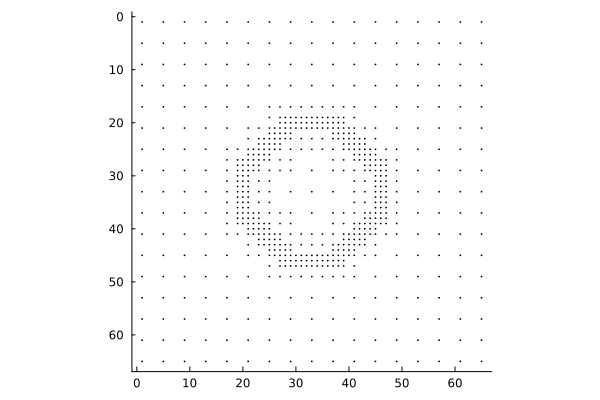

In [127]:
spy(my_arr)